# Experiments

In [1]:
from src.pose_estimator import PoseEstimator
from src.camera_config.pixel7 import Pixel7
from src.feature_matcher.image_matching_models import ImageMatchingModels
from src.pnp.opencv_pnp import OpenCVPNP
from src.pnp.ippe import IPPE
from src.pnp.pnp_refine import PNPRefine
from src.analytics import Analytics
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

c:\Users\Daniel Dai\Documents\McGill\COMP558\Project\planar-pose-estimation\src\feature_matcher\..\..\image-matching-models\matching\third_party\LightGlue\lightglue\lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


Using default device: cuda


## Helper Functions

### Config

In [9]:
BOX_CLOSE_TEST = {
    "name": "box_close",
    "base_image_path": "images/base_box.jpg",
    "video_path": "videos/video_box_close.mp4",
    "camera_config": Pixel7(),
}

BOX_FAR_TEST = {
    "name": "box_far",
    "base_image_path": "images/base_box.jpg",
    "video_path": "videos/video_box_far.mp4",
    "camera_config": Pixel7(),
}

GUITAR_TEST = {
    "name": "guitar",
    "base_image_path": "images/base_guitar.png",
    "video_path": "videos/video_guitar.mp4",
    "camera_config": Pixel7(),
}

TESTS = [BOX_CLOSE_TEST, BOX_FAR_TEST, GUITAR_TEST]

pnps = [
    OpenCVPNP("iterative_pnp", cv2.SOLVEPNP_ITERATIVE),
    OpenCVPNP("epnp", cv2.SOLVEPNP_EPNP),
    OpenCVPNP("opencv_ippe", cv2.SOLVEPNP_IPPE),
    PNPRefine(OpenCVPNP("opencv_ippe", cv2.SOLVEPNP_IPPE)),
    IPPE(),
]

SIFT_LG = ImageMatchingModels("sift-lg")
SIFT_NN = ImageMatchingModels("sift-nn")
ORB_NN = ImageMatchingModels("orb-nn")

### Show Analytics Function

In [10]:
def show_analytics(analytics):
    for analytic in analytics:
        analytic.print_results()
        print()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot FPS history
    for analytic in analytics:
        axes[0].plot(analytic.fps_history, label=analytic.name)
    axes[0].set_title('FPS History')
    axes[0].set_xlabel('Frame')
    axes[0].set_ylabel('FPS')
    axes[0].legend()

    # Plot PnP time history
    for analytic in analytics:
        axes[1].plot(analytic.pnp_time_history, label=analytic.name)
    axes[1].set_title('PnP Time History')
    axes[1].set_xlabel('Frame')
    axes[1].set_ylabel('PnP Time (s)')
    axes[1].legend()

    # Plot feature match time history
    for analytic in analytics:
        axes[2].plot(analytic.feature_match_time_history, label=analytic.name)
    axes[2].set_title('Feature Match Time History')
    axes[2].set_xlabel('Frame')
    axes[2].set_ylabel('Feature Match Time (s)')
    axes[2].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

    # Plot reprojection error history
    plt.figure(figsize=(10, 6))
    for analytic in analytics:
        plt.plot(analytic.reprojection_error_history, label=analytic.name)
    plt.title('Reprojection Error History')
    plt.xlabel('Frame')
    plt.ylabel('Reprojection Error')
    plt.legend()
    plt.show()

    def show_frame(frame_idx):
        fig, axes = plt.subplots(1, len(analytics), figsize=(15, 5))

        for i, analytic in enumerate(analytics):
            axes[i].imshow(analytic.output_frames[frame_idx])
            axes[i].set_title(f'{analytic.name} - Frame {frame_idx}')
            axes[i].axis('off')
        
        plt.show()

    # Create an interactive slider
    _ = interact(show_frame, frame_idx=IntSlider(min=0, max=len(analytics[0].output_frames)-1, step=1, value=0))

### Test PnP Algorithms

In [11]:
def test_pnps(test_type, feature_matcher, use_ransac=False, use_lucas_kanade=False):
    analytics = []
    for pnp in pnps:
        name = test_type["name"] + " - " + feature_matcher.matcher_name + " - " + pnp.name
        if use_ransac:
            name += " - RANSAC"
        pose_estimator = PoseEstimator(test_type["camera_config"], feature_matcher, pnp)
        analytic = Analytics(name)
        pose_estimator.video_estimate_pose(test_type["base_image_path"], test_type["video_path"], use_ransac=use_ransac, use_lucas_kanade=use_lucas_kanade, analytics=analytic, show_frame_pose=True)

        analytics.append(analytic)

    show_analytics(analytics)

### Execute test

In [12]:
def execute_test(test_type, feature_matcher):
    print("Testing without RANSAC:\n")
    test_pnps(test_type, feature_matcher)

    print("\n\nTesting with RANSAC:\n")
    test_pnps(test_type, feature_matcher, use_ransac=True)

### Playground (scrap)

In [6]:
# camera_config = Pixel7()
# feature_matcher = ImageMatchingModels("sift-lg")
# pnp = OpenCVPNP(cv2.SOLVEPNP_IPPE)
# sift_lg_analytics = Analytics("sift_lg")
# pose_estimator = PoseEstimator(camera_config, feature_matcher, pnp)
# pose_estimator.video_estimate_pose("images/base_box.jpg", "videos/video_box_test.mp4", analytics=sift_lg_analytics)

# camera_config = Pixel7()
# feature_matcher = ImageMatchingModels("sift-nn")
# pnp = OpenCVPNP(cv2.SOLVEPNP_IPPE)
# sift_nn_analytics = Analytics("sift_nn")
# pose_estimator = PoseEstimator(camera_config, feature_matcher, pnp)
# pose_estimator.video_estimate_pose("images/base_box.jpg", "videos/video_box_test.mp4", analytics=sift_nn_analytics)

# analytics = [sift_lg_analytics, sift_nn_analytics]

# camera_config = Pixel7()
# feature_matcher = ImageMatchingModels("superpoint-lg")
# pnp = OpenCVPNP(cv2.SOLVEPNP_IPPE)
# superpoint_analytics = Analytics("superpoint-lg")
# pose_estimator = PoseEstimator(camera_config, feature_matcher, pnp)
# pose_estimator.video_estimate_pose("images/base_box.jpg", "videos/video_box_test.mp4", use_lucas_kanade=True, show_frame_pose=True, analytics=superpoint_analytics)

# analytics = [superpoint_analytics, superpoint_analytics]

## Box Close Experiment

### Sift + Lightglue

Testing without RANSAC:

Analytics for box_close - sift-lg - iterative_pnp
Total time: 128.45368480682373s
Average FPS: 2.918858049329947
Average PnP time: 0.0014258778326399098s
Average feature match time: 0.33769981088400564s
Average reprojection error: 9.907253757430542
Failed frames: 0

Analytics for box_close - sift-lg - epnp
Total time: 125.22656488418579s
Average FPS: 2.956162113061344
Average PnP time: 0.0001683175728922075s
Average feature match time: 0.32986520135831965s
Average reprojection error: 22.815921332746054
Failed frames: 0

Analytics for box_close - sift-lg - opencv_ippe
Total time: 120.43424010276794s
Average FPS: 3.0777263974813036
Average PnP time: 0.0001957145754320138s
Average feature match time: 0.31730760827949506s
Average reprojection error: 12.908262452691302
Failed frames: 0

Analytics for box_close - sift-lg - opencv_ippe + Refine
Total time: 117.3321681022644s
Average FPS: 3.1557920620684983
Average PnP time: 0.00159148298142029s
Average feature match t

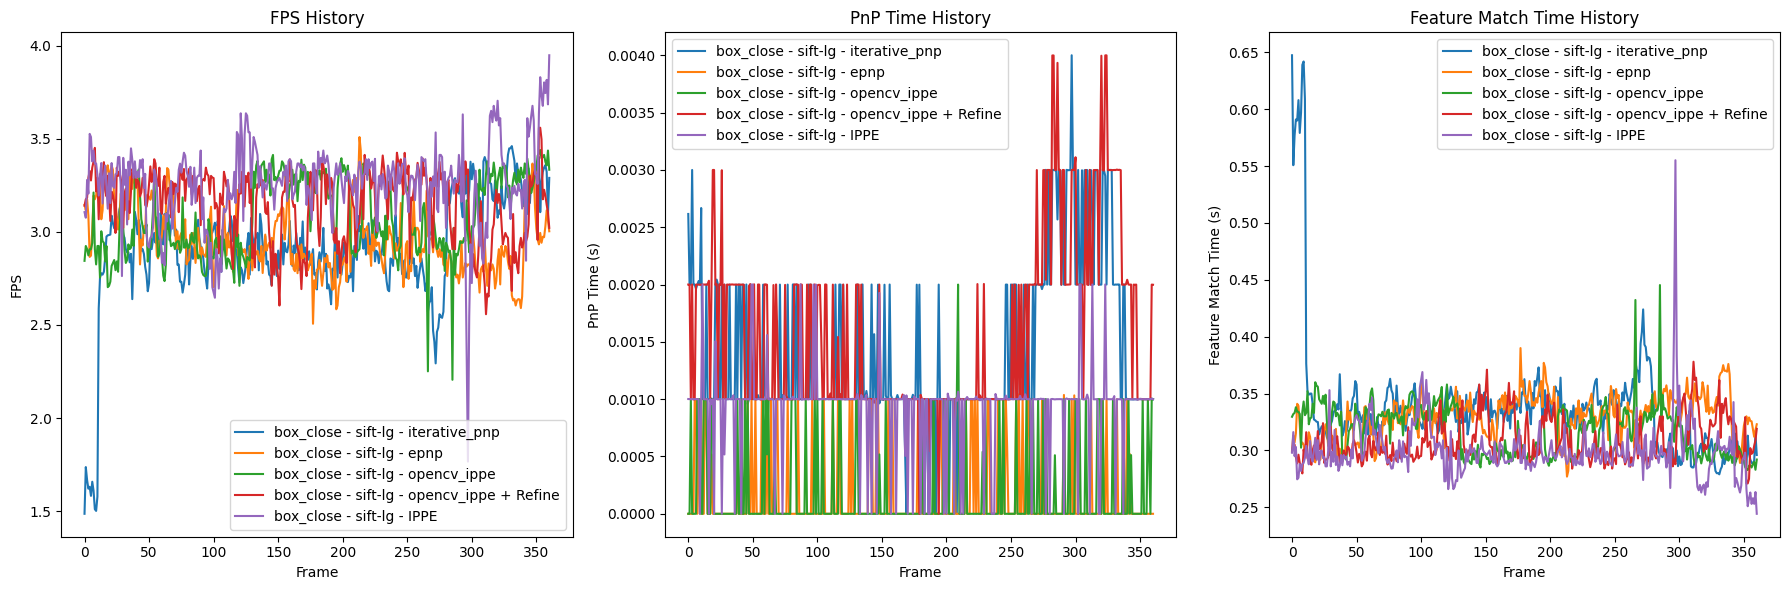

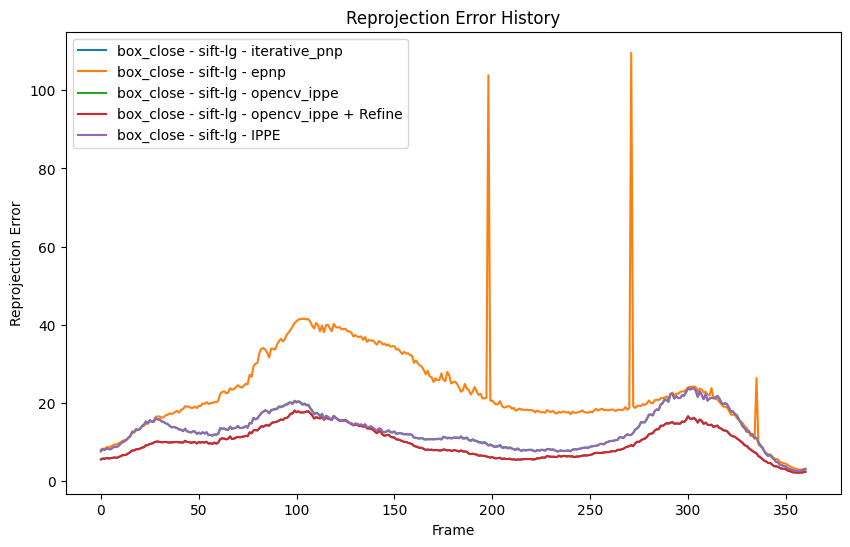

interactive(children=(IntSlider(value=0, description='frame_idx', max=360), Output()), _dom_classes=('widget-i…



Testing with RANSAC:

Analytics for box_close - sift-lg - iterative_pnp - RANSAC
Total time: 115.15023255348206s
Average FPS: 3.2129276524170653
Average PnP time: 0.005784069071846327s
Average feature match time: 0.29831756449141994s
Average reprojection error: 11.641710177422478
Failed frames: 0

Analytics for box_close - sift-lg - epnp - RANSAC
Total time: 116.7463104724884s
Average FPS: 3.168660321686284
Average PnP time: 0.005476711199224161s
Average feature match time: 0.3029834781657295s
Average reprojection error: 19.402176651936355
Failed frames: 0

Analytics for box_close - sift-lg - opencv_ippe - RANSAC
Total time: 118.9644238948822s
Average FPS: 3.1086563728162577
Average PnP time: 0.005515396429891401s
Average feature match time: 0.3086916462536335s
Average reprojection error: 12.88605055812123
Failed frames: 0

Analytics for box_close - sift-lg - opencv_ippe + Refine - RANSAC
Total time: 118.58624911308289s
Average FPS: 3.1162569049400637
Average PnP time: 0.006872517910

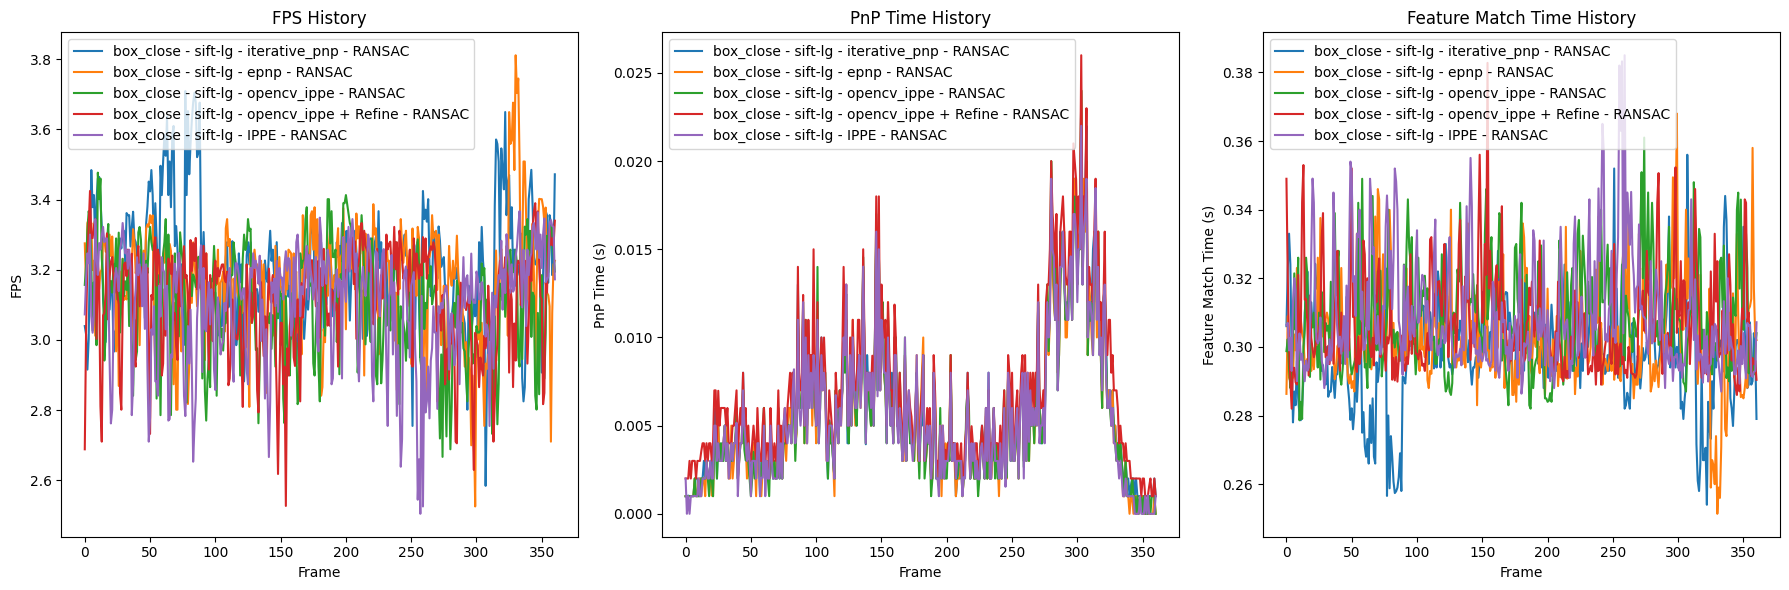

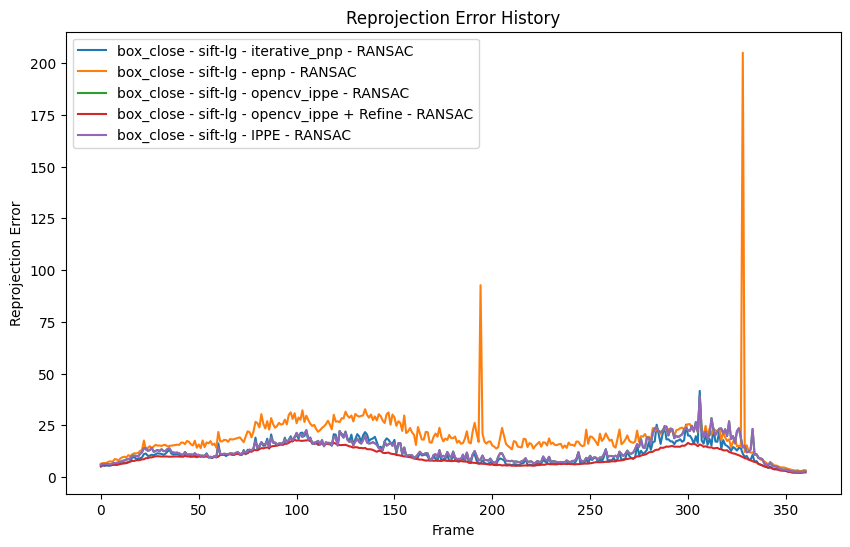

interactive(children=(IntSlider(value=0, description='frame_idx', max=360), Output()), _dom_classes=('widget-i…

In [16]:
execute_test(BOX_CLOSE_TEST, SIFT_LG)

### Sift + Nearest Neighbour

Testing without RANSAC:

Analytics for box_close - sift-nn - iterative_pnp
Total time: 419.7008922100067s
Average FPS: 0.8659382714984879
Average PnP time: 0.0011750317676575896s
Average feature match time: 1.1444114793370632s
Average reprojection error: 151.51647937812422
Failed frames: 0

Analytics for box_close - sift-nn - epnp
Total time: 423.6378240585327s
Average FPS: 0.8575678791448458
Average PnP time: 0.00010539620206626821s
Average feature match time: 1.1568867605478808s
Average reprojection error: 230.32639503788027
Failed frames: 0

Analytics for box_close - sift-nn - opencv_ippe
Total time: 425.55764865875244s
Average FPS: 0.8536880122901481
Average PnP time: 0.000140988595597962s
Average feature match time: 1.161873586950541s
Average reprojection error: 175.62062370244558
Failed frames: 0

Analytics for box_close - sift-nn - opencv_ippe + Refine
Total time: 791.1880145072937s
Average FPS: 0.4705877111456851
Average PnP time: 0.0019709211967658463s
Average feature match ti

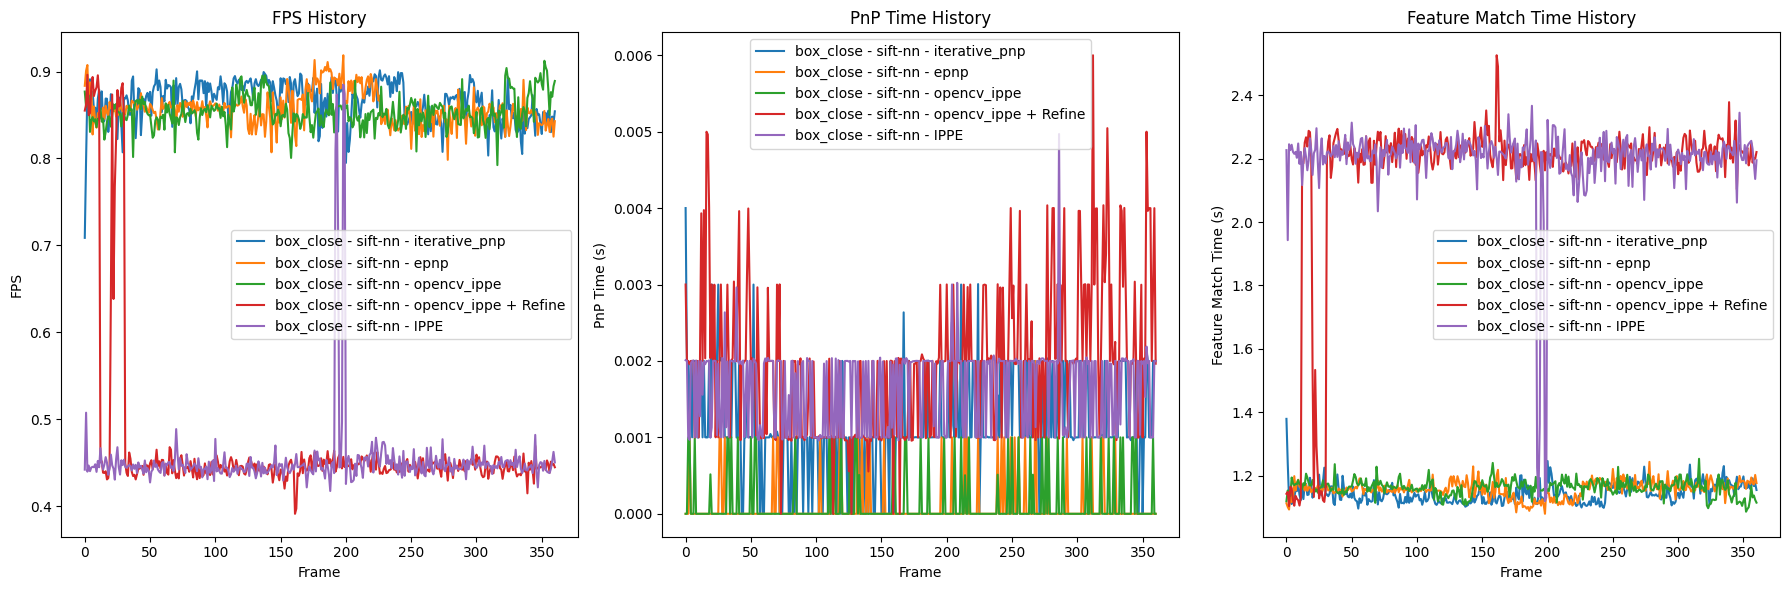

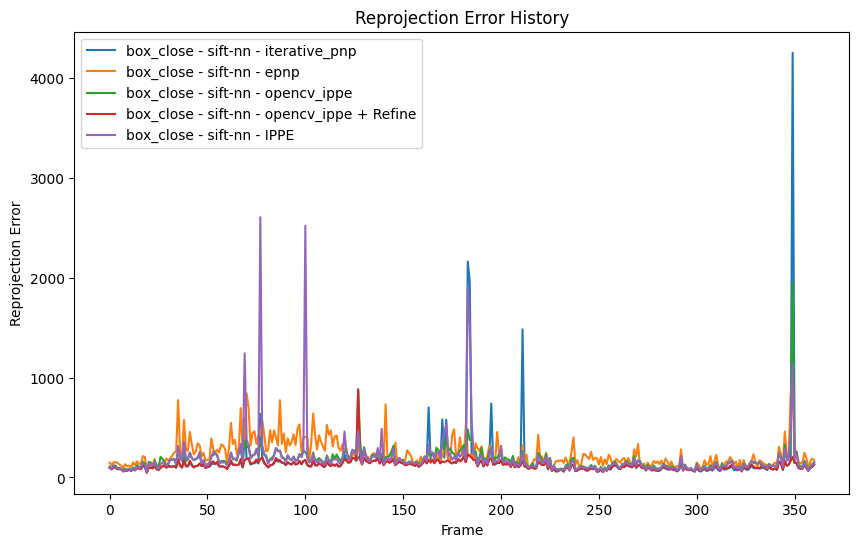

interactive(children=(IntSlider(value=0, description='frame_idx', max=360), Output()), _dom_classes=('widget-i…



Testing with RANSAC:

Analytics for box_close - sift-nn - iterative_pnp - RANSAC
Total time: 606.0313258171082s
Average FPS: 0.6690690294817899
Average PnP time: 0.009813337775148513s
Average feature match time: 1.6434827187715144s
Average reprojection error: 88.26296780155972
Failed frames: 0

Analytics for box_close - sift-nn - epnp - RANSAC
Total time: 842.9002664089203s
Average FPS: 0.43054856735367364
Average PnP time: 0.013486949360601793s
Average feature match time: 2.2853936435773434s
Average reprojection error: 92.73238443369459
Failed frames: 0

Analytics for box_close - sift-nn - opencv_ippe - RANSAC
Total time: 820.2653751373291s
Average FPS: 0.4428460556653065
Average PnP time: 0.01311873663165233s
Average feature match time: 2.2232948393042404s
Average reprojection error: 158.0394931723692
Failed frames: 0

Analytics for box_close - sift-nn - opencv_ippe + Refine - RANSAC
Total time: 849.0166711807251s
Average FPS: 0.42730706870753515
Average PnP time: 0.015985835622222

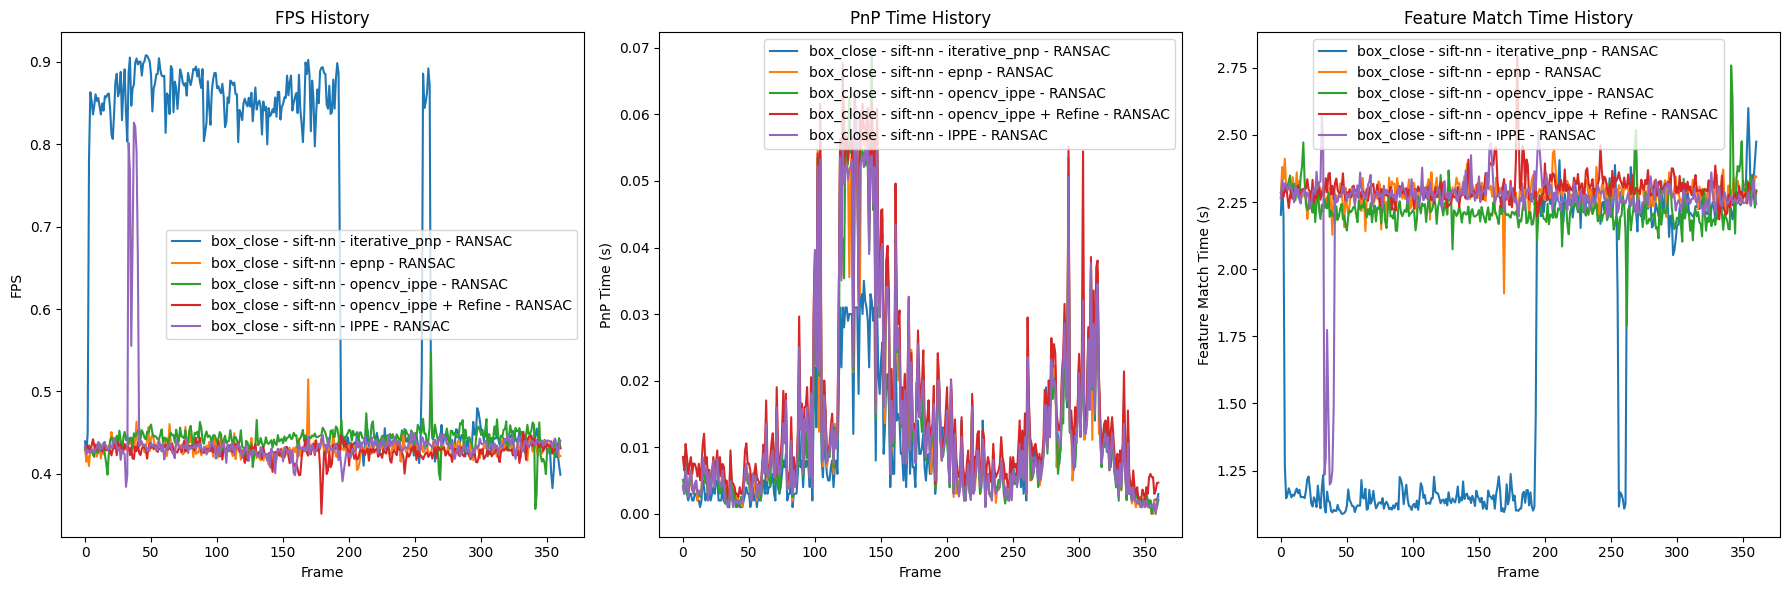

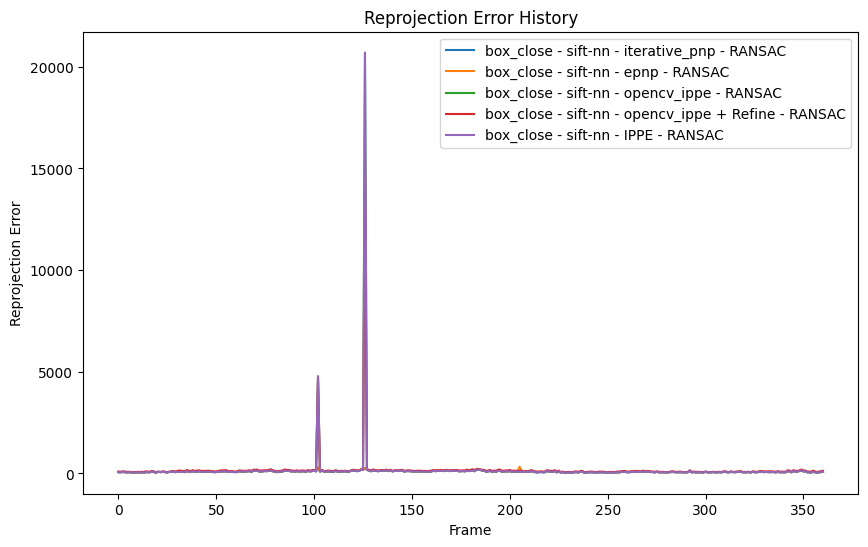

interactive(children=(IntSlider(value=0, description='frame_idx', max=360), Output()), _dom_classes=('widget-i…

In [17]:
execute_test(BOX_CLOSE_TEST, SIFT_NN)

### ORB + Nearest Neighbour

Testing without RANSAC:

Analytics for box_close - orb-nn - iterative_pnp
Total time: 190.8844919204712s
Average FPS: 1.9324212691652085
Average PnP time: 0.0011393898411800986s
Average feature match time: 0.49385090878135285s
Average reprojection error: 303.0443883098167
Failed frames: 0

Analytics for box_close - orb-nn - epnp
Total time: 197.9842185974121s
Average FPS: 1.862517658232591
Average PnP time: 0.00015271667628407153s
Average feature match time: 0.5141706308169384s
Average reprojection error: 941.0867195653094
Failed frames: 0

Analytics for box_close - orb-nn - opencv_ippe
Total time: 199.97540807724s
Average FPS: 1.842239625063514
Average PnP time: 0.00013433533031854608s
Average feature match time: 0.5188451797347975s
Average reprojection error: 429.5515488346785
Failed frames: 0

Analytics for box_close - orb-nn - opencv_ippe + Refine
Total time: 200.8075053691864s
Average FPS: 1.8364266135275749
Average PnP time: 0.0007732997640678429s
Average feature match time: 0.52

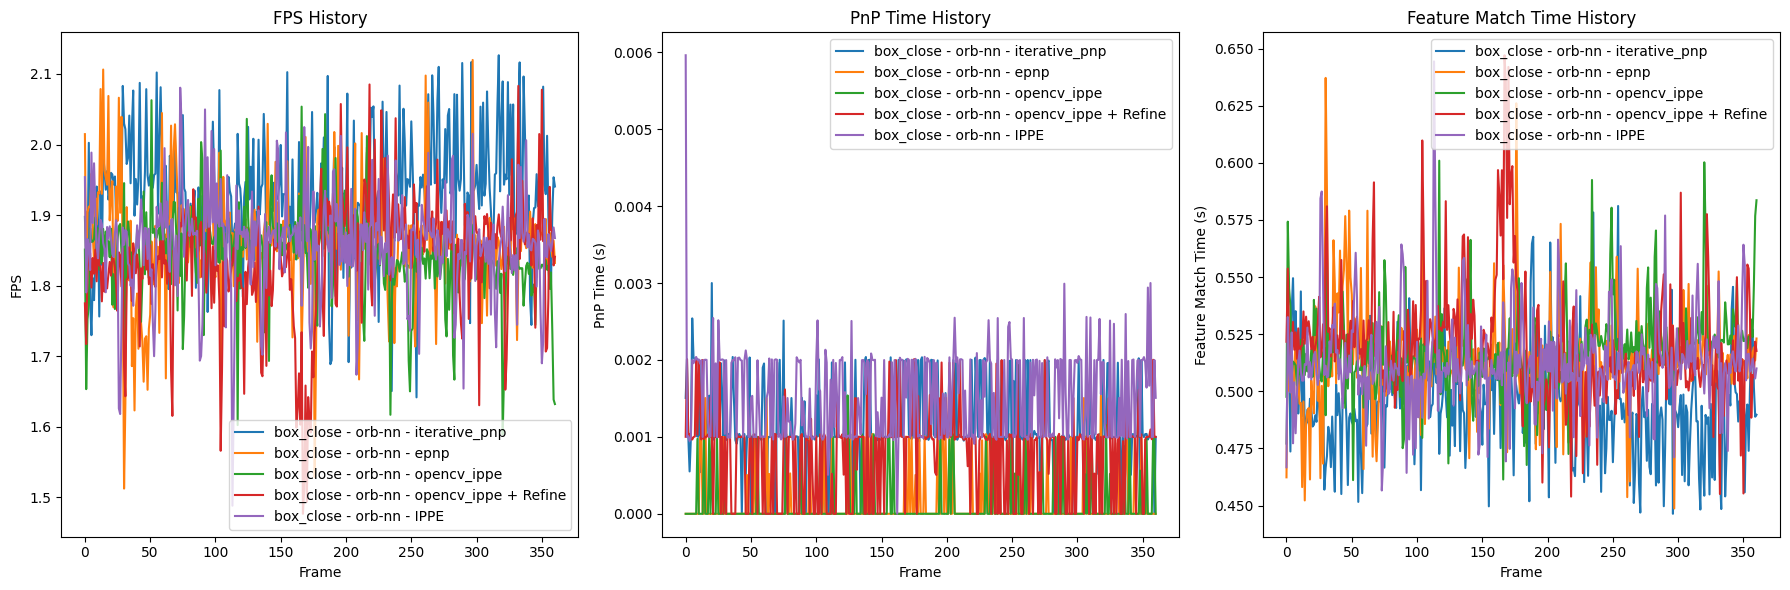

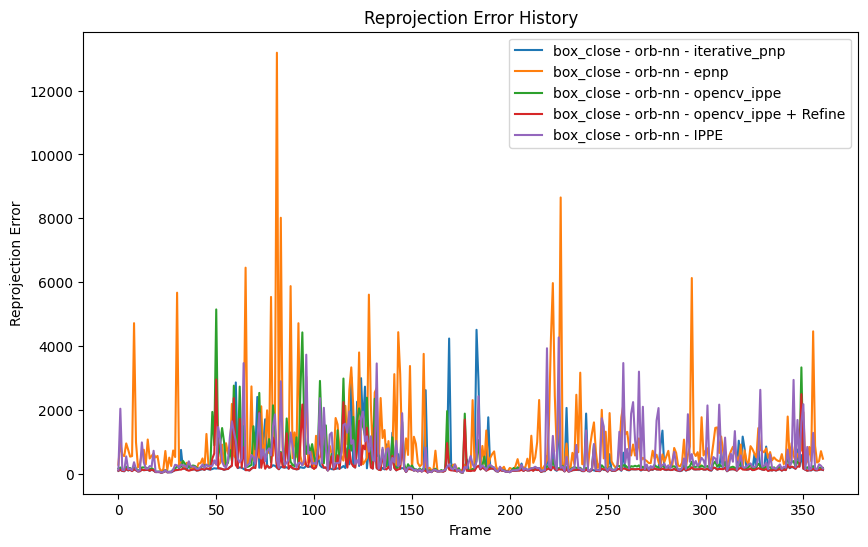

interactive(children=(IntSlider(value=0, description='frame_idx', max=360), Output()), _dom_classes=('widget-i…



Testing with RANSAC:

Analytics for box_close - orb-nn - iterative_pnp - RANSAC
Total time: 208.85979104042053s
Average FPS: 1.7660620949363808
Average PnP time: 0.011723040873984555s
Average feature match time: 0.5306258663906614s
Average reprojection error: 119.66102299005861
Failed frames: 0

Analytics for box_close - orb-nn - epnp - RANSAC
Total time: 207.98804473876953s
Average FPS: 1.773040070687943
Average PnP time: 0.011605933762653373s
Average feature match time: 0.5282172720848358s
Average reprojection error: 127.8570368397826
Failed frames: 0

Analytics for box_close - orb-nn - opencv_ippe - RANSAC
Total time: 207.12016463279724s
Average FPS: 1.7801676924634375
Average PnP time: 0.011505541708991152s
Average feature match time: 0.5258757090634592s
Average reprojection error: 121.18399330295419
Failed frames: 0

Analytics for box_close - orb-nn - opencv_ippe + Refine - RANSAC
Total time: 206.73037457466125s
Average FPS: 1.7867885688665712
Average PnP time: 0.012216536952518

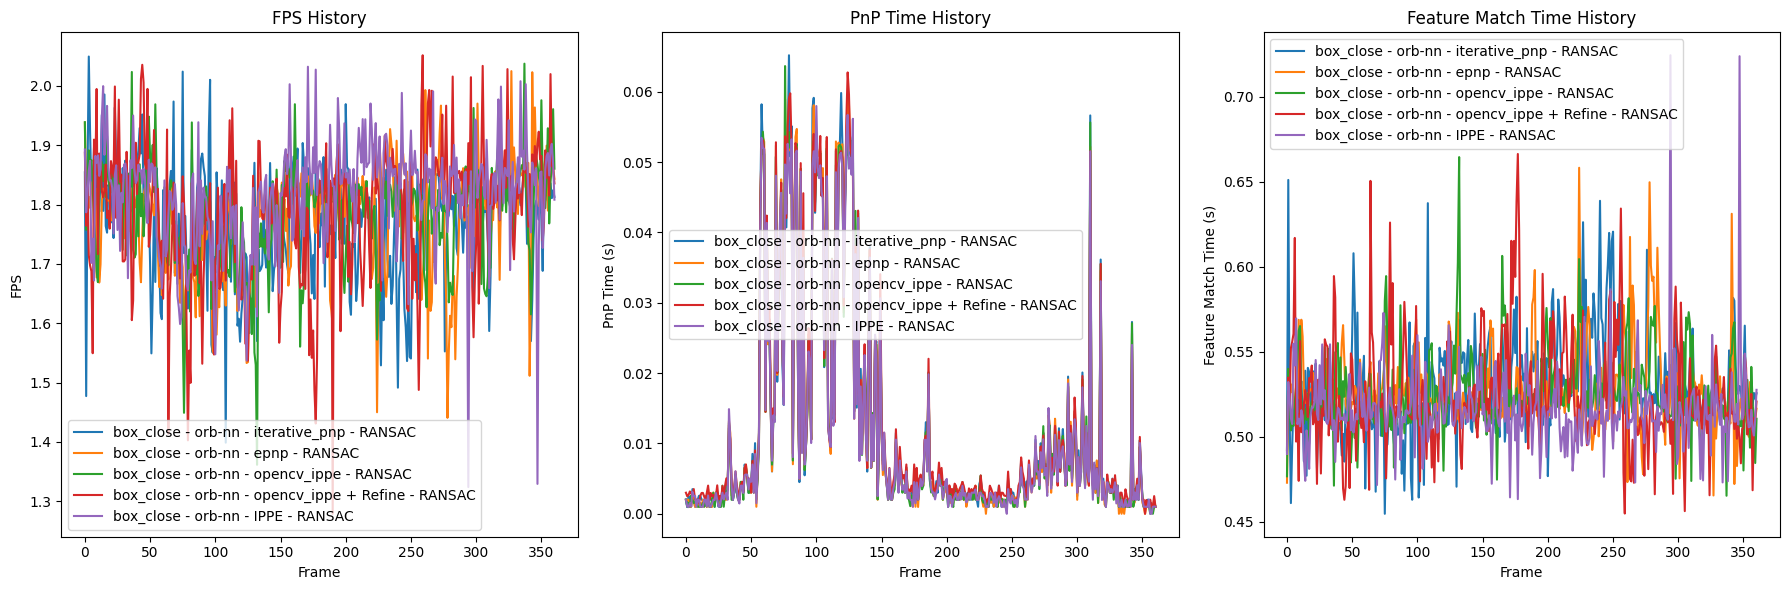

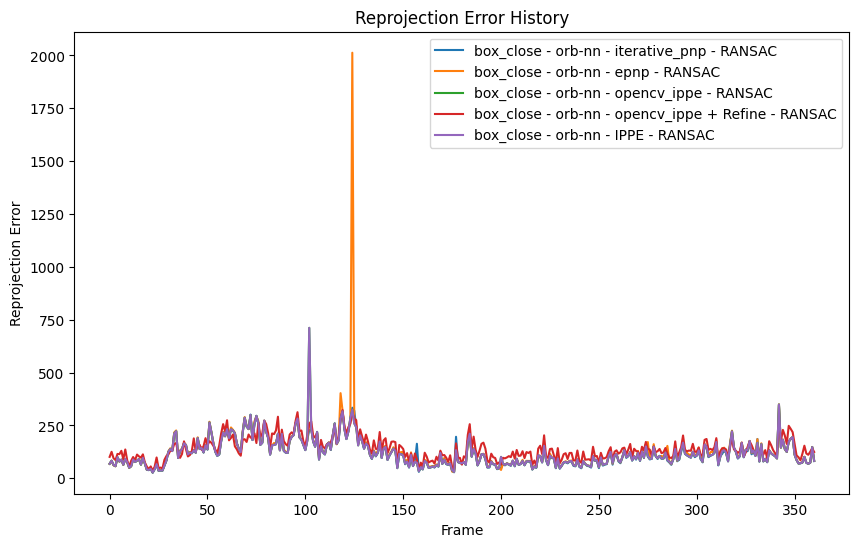

interactive(children=(IntSlider(value=0, description='frame_idx', max=360), Output()), _dom_classes=('widget-i…

In [18]:
execute_test(BOX_CLOSE_TEST, ORB_NN)

## Box Far Experiment

### Sift + Lightglue

Testing without RANSAC:

Exception: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\solvepnp.cpp:825: error: (-215:Assertion failed) ( (npoints >= 4) || (npoints == 3 && flags == SOLVEPNP_ITERATIVE && useExtrinsicGuess) || (npoints >= 3 && flags == SOLVEPNP_SQPNP) ) && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'cv::solvePnPGeneric'

Exception: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\solvepnp.cpp:825: error: (-215:Assertion failed) ( (npoints >= 4) || (npoints == 3 && flags == SOLVEPNP_ITERATIVE && useExtrinsicGuess) || (npoints >= 3 && flags == SOLVEPNP_SQPNP) ) && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'cv::solvePnPGeneric'

Exception: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\solvepnp.cpp:825: error: (-215:Assertion failed) ( (npoints >= 4) || (npoints == 3 && flags == SOLVEPNP_ITE

c:\Users\Daniel Dai\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Daniel Dai\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Exception: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:390: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'

Exception: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:390: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'

Exception: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:390: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'

Exception: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:390: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate H

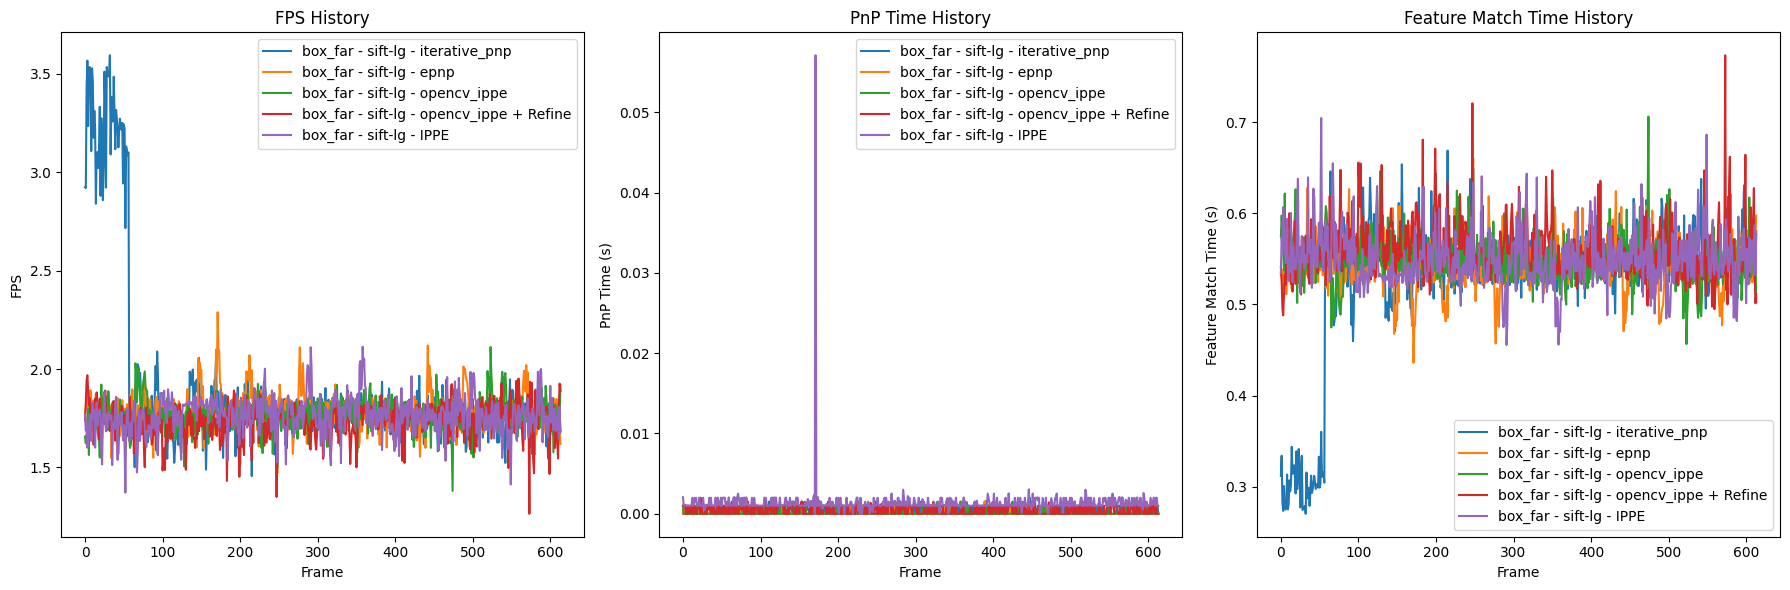

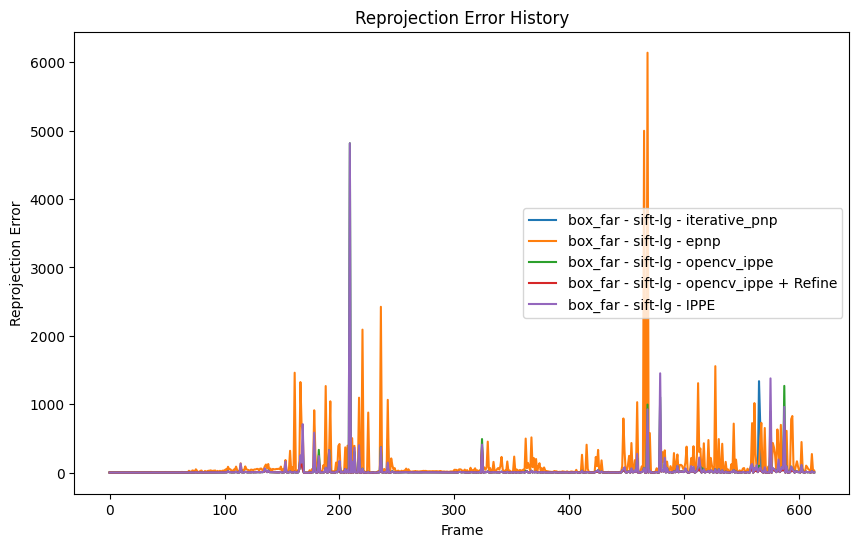

interactive(children=(IntSlider(value=0, description='frame_idx', max=613), Output()), _dom_classes=('widget-i…



Testing with RANSAC:

Exception: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\solvepnp.cpp:227: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'cv::solvePnPRansac'

Exception: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\solvepnp.cpp:227: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'cv::solvePnPRansac'

Exception: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\solvepnp.cpp:227: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'cv::solvePnPRansac'

Exception: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\solvepnp.cpp:227: error: (-215:Assertion failed) npoints >= 4 && npoints == std::ma

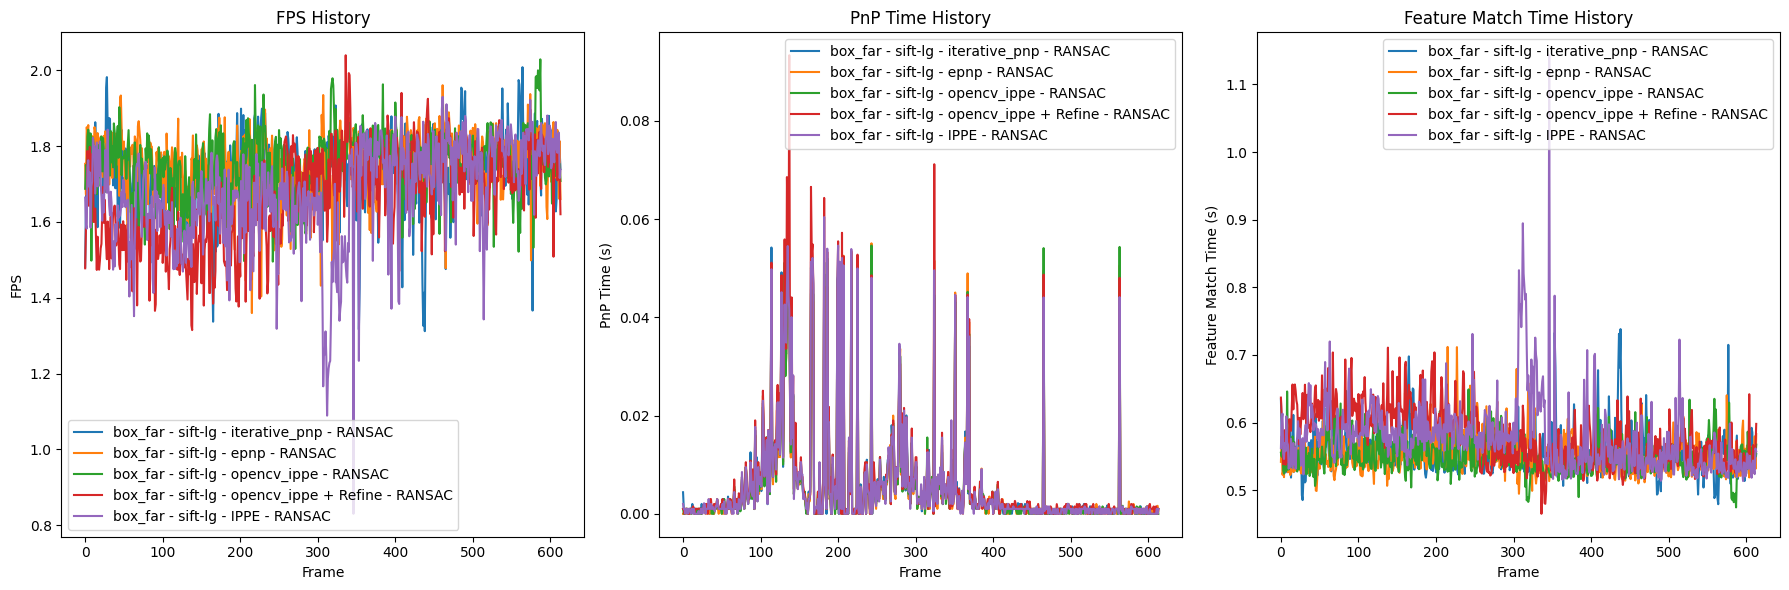

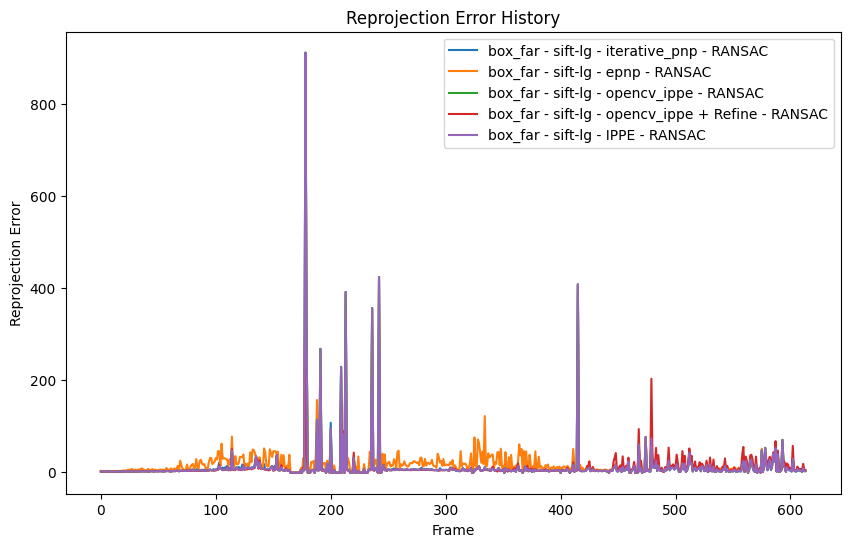

interactive(children=(IntSlider(value=0, description='frame_idx', max=613), Output()), _dom_classes=('widget-i…

In [6]:
execute_test(BOX_FAR_TEST, SIFT_LG)

### Sift + Nearest Neighbour

In [ ]:
# execute_test(BOX_FAR_TEST, SIFT_NN) # Do not require to test

### ORB + Nearest Neighbour

In [ ]:
# execute_test(BOX_FAR_TEST, ORB_NN) # Do not require to test

## Guitar Experiment

### Sift + Lightglue

Testing without RANSAC:

Exception: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\solvepnp.cpp:825: error: (-215:Assertion failed) ( (npoints >= 4) || (npoints == 3 && flags == SOLVEPNP_ITERATIVE && useExtrinsicGuess) || (npoints >= 3 && flags == SOLVEPNP_SQPNP) ) && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'cv::solvePnPGeneric'

Exception: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\solvepnp.cpp:825: error: (-215:Assertion failed) ( (npoints >= 4) || (npoints == 3 && flags == SOLVEPNP_ITERATIVE && useExtrinsicGuess) || (npoints >= 3 && flags == SOLVEPNP_SQPNP) ) && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'cv::solvePnPGeneric'

Exception: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\solvepnp.cpp:825: error: (-215:Assertion failed) ( (npoints >= 4) || (npoints == 3 && flags == SOLVEPNP_ITE

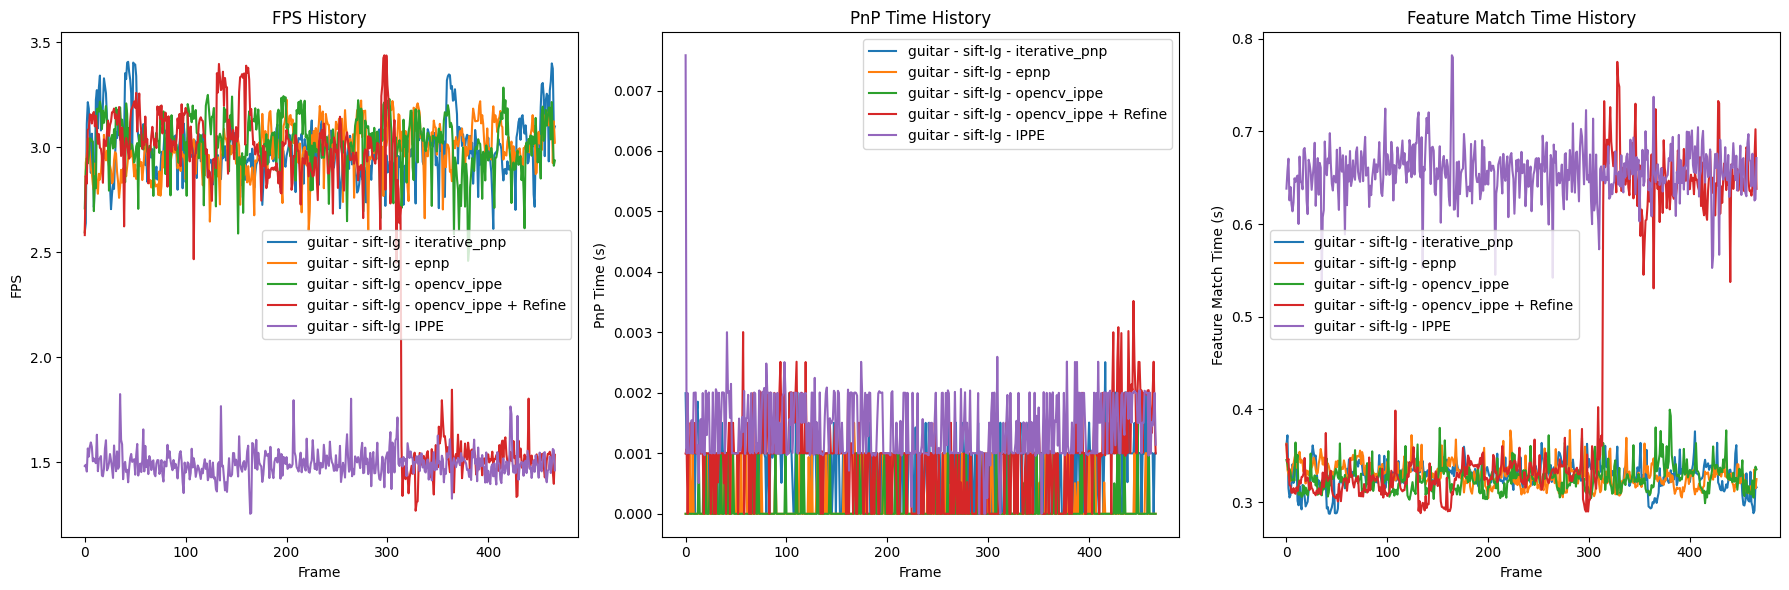

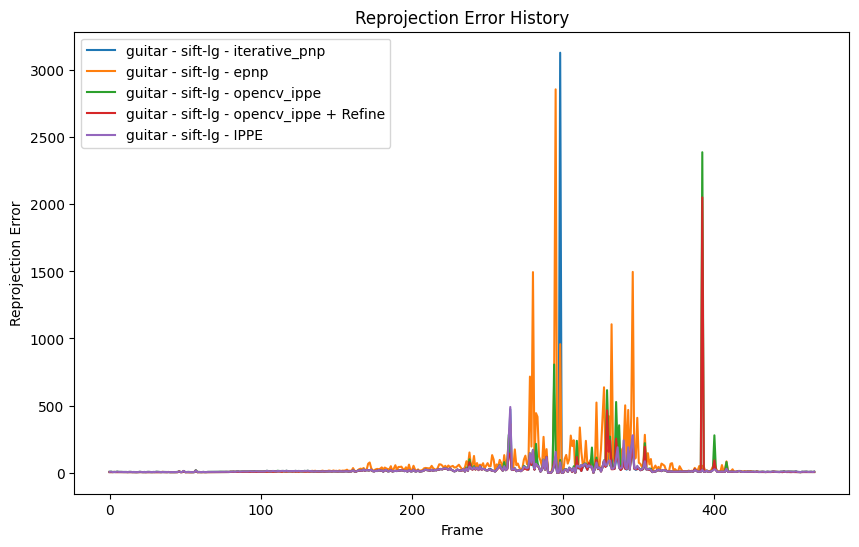

interactive(children=(IntSlider(value=0, description='frame_idx', max=466), Output()), _dom_classes=('widget-i…



Testing with RANSAC:

Exception: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\solvepnp.cpp:227: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'cv::solvePnPRansac'

Exception: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\solvepnp.cpp:227: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'cv::solvePnPRansac'

Exception: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\solvepnp.cpp:227: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'cv::solvePnPRansac'

Exception: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\solvepnp.cpp:227: error: (-215:Assertion failed) npoints >= 4 && npoints == std::ma

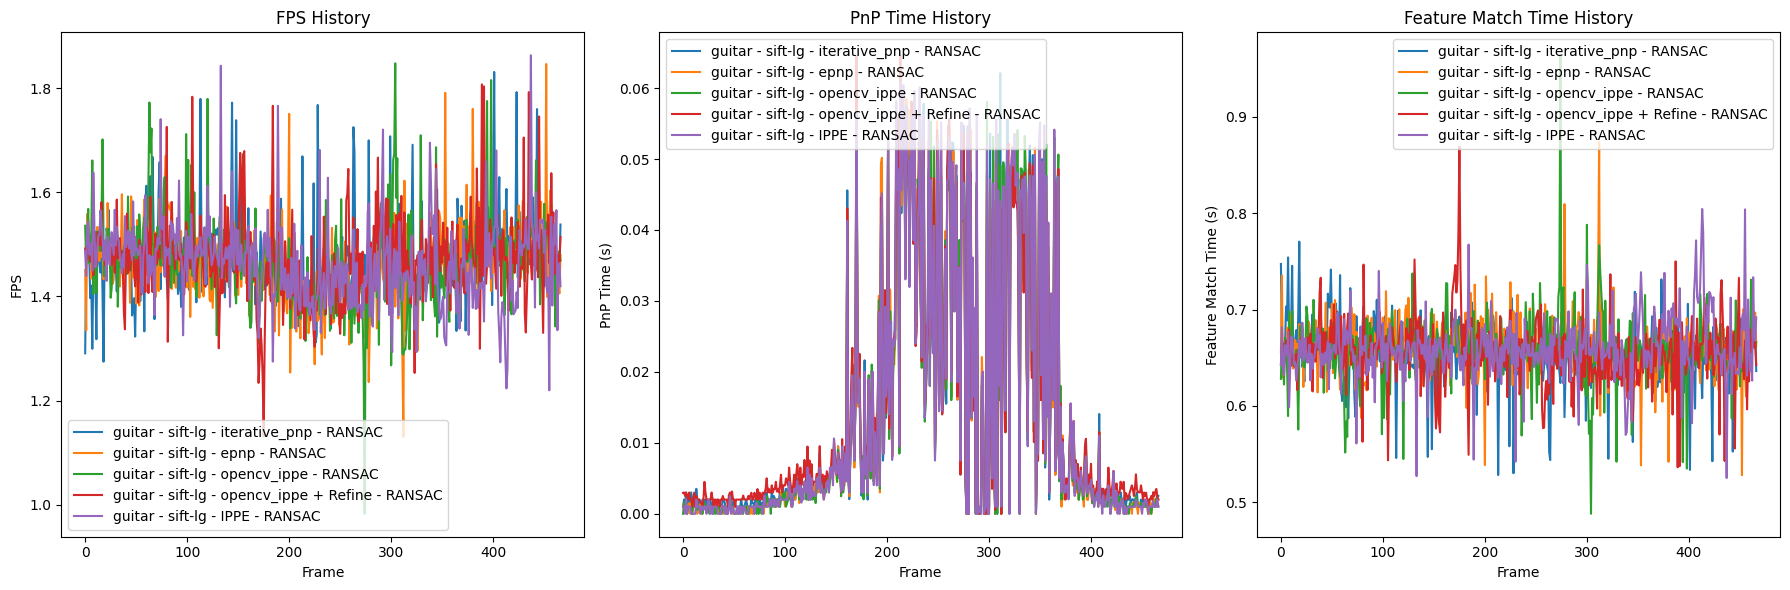

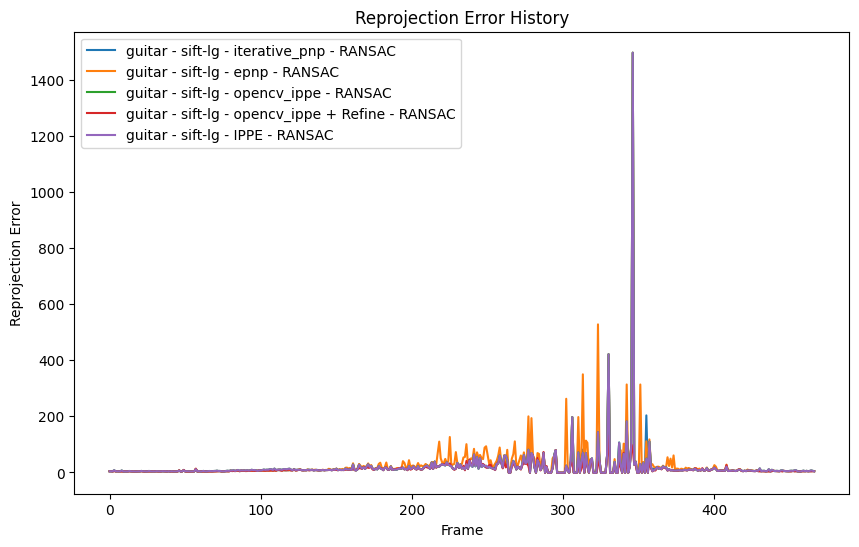

interactive(children=(IntSlider(value=0, description='frame_idx', max=466), Output()), _dom_classes=('widget-i…

In [13]:
execute_test(GUITAR_TEST, SIFT_LG)

### Sift + Nearest Neighbour

In [ ]:
# execute_test(GUITAR_TEST, SIFT_NN) # Do not require to test

### ORB + Nearest Neighbour

In [ ]:
# execute_test(GUITAR_TEST, ORB_NN) # Do not require to test

## Lucas Kanade Video Experiment

Analytics for box_close - sift-lg - iterative_pnp
Total time: 8.687525749206543s
Average FPS: 62.353968546817796
Average PnP time: 0.0013788941824535244s
Average feature match time: 0.006637276044512719s
Average reprojection error: 15.201507195054605
Failed frames: 0

Analytics for box_close - sift-lg - epnp
Total time: 8.169241905212402s
Average FPS: 67.64523627282429
Average PnP time: 0.0001497196028437311s
Average feature match time: 0.006611592221458208s
Average reprojection error: 28.06905026283555
Failed frames: 0

Analytics for box_close - sift-lg - opencv_ippe
Total time: 8.244842767715454s
Average FPS: 66.83695737030338
Average PnP time: 0.0001211800403542135s
Average feature match time: 0.006773187843386153s
Average reprojection error: 17.157521437420204
Failed frames: 0

Analytics for box_close - sift-lg - opencv_ippe + Refine
Total time: 8.739480257034302s
Average FPS: 61.80945223846098
Average PnP time: 0.0014327199835526324s
Average feature match time: 0.00682217328502201

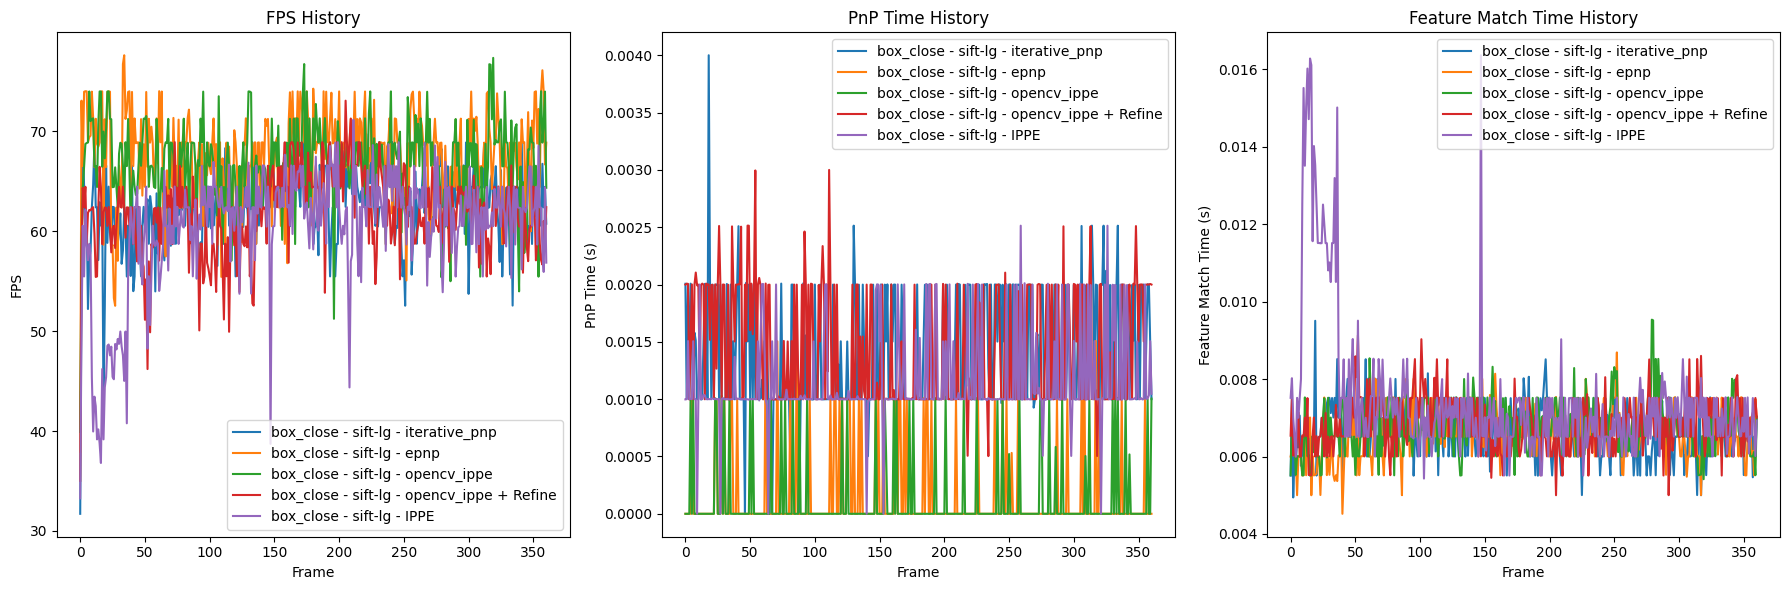

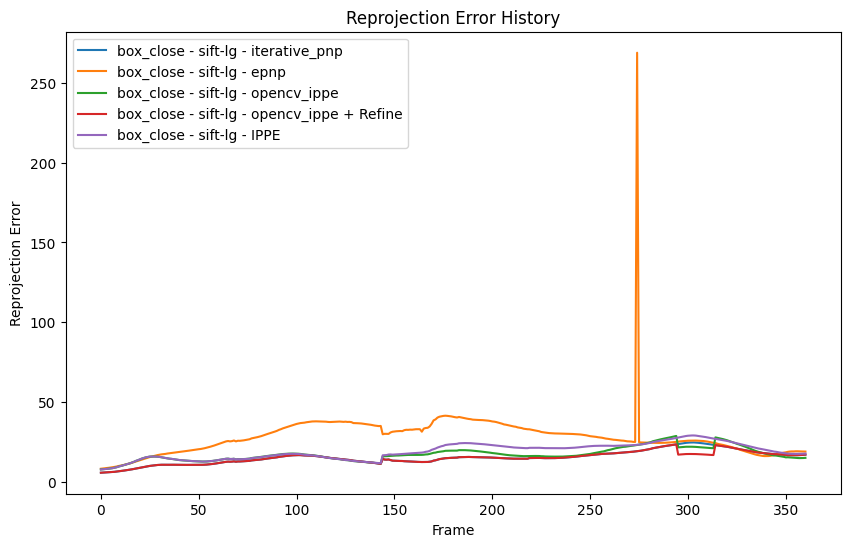

interactive(children=(IntSlider(value=0, description='frame_idx', max=360), Output()), _dom_classes=('widget-i…

In [15]:
test_pnps(BOX_CLOSE_TEST, SIFT_LG, use_lucas_kanade=True)